### Load nodes to dataframe

In [49]:
import os
import sys
sys.path.insert(0, os.path.abspath('../..'))
from experiment.step_2_cluster.tsne_util import load_5_documents_nodes
import pandas as pd

def find_root(x):
    while nodeId2ref[x] != None:
        x = nodeId2ref[x]
    return x

target_nodes = load_5_documents_nodes()
nodeId2ref = {node.id_: node.ref_doc_id if node.metadata['level'] != 'document' else None for node in target_nodes}


Loading 0.jsonl: 100%|██████████| 979M/979M [01:17<00:00, 13.3MB/s] 


Root
├── Document 3d751495-ce66-4254-a79f-ed8d740b9424
│   ├── section Node 71503056-c446-457a-91a4-7c1ab3ef6e97
│   │   ├── paragraph Node 85fd699a-076f-4854-ac54-571c1827b6fd
│   │   │   └── multi-sentences Node 346ae7ba-5da8-4d43-8961-fad3b57edf89
│   │   ├── paragraph Node e9e3a510-41f6-4cc8-8f2b-a159e3049380
│   │   │   ├── multi-sentences Node 6cdd91a8-92b4-42a9-be7b-c99ab4514803
│   │   │   └── multi-sentences Node ed09992c-7852-4561-b8fb-16ed13ff9cfb
│   │   ├── paragraph Node fca0fe0e-ad12-4413-9047-92b77ec815a4
│   │   │   └── multi-sentences Node bced6e6e-d91e-4949-8115-ae4a5248b7aa
│   │   ├── paragraph Node da081b50-0924-4f02-a06b-f1829cf0182a
│   │   │   ├── multi-sentences Node 2f7ccf0a-faa7-40e4-8ab3-a1640f908d69
│   │   │   ├── multi-sentences Node c05b4b79-9a59-4764-a1a3-37a50987cff1
│   │   │   ├── multi-sentences Node 0ffed2f1-b47d-4a68-a672-21380fca94d5
│   │   │   ├── multi-sentences Node 3af56116-3811-46d0-9b25-a4405aaceb6e
│   │   │   ├── multi-sentences Node ab

In [50]:
df_total = pd.DataFrame({
    'embeddings': [tuple(node.embedding) for node in target_nodes],
    'levels': [node.metadata['level'] for node in target_nodes],
    'doc_id': [find_root(node.id_) for node in target_nodes]
})

### Check if the value are unique

In [51]:
def unique_values_at_different_levels(filtered_df):
    # Count unique tsne values for each level
    doc_count = len(filtered_df[filtered_df['levels'] == 'document']['embeddings'].unique())
    section_count = len(filtered_df[filtered_df['levels'] == 'section']['embeddings'].unique())
    paragraph_count = len(filtered_df[filtered_df['levels'] == 'paragraph']['embeddings'].unique())
    multi_sent_count = len(filtered_df[filtered_df['levels'] == 'multi-sentences']['embeddings'].unique())

    # Print formatted results
    print(f"Document number of df: {len(filtered_df[filtered_df['levels'] == 'document'])}")
    print(f"Unique embeddings counts:")
    print(f"Document: {doc_count}")
    print(f"Section: {section_count}")
    print(f"Paragraph: {paragraph_count}")
    print(f"Multi-Sentences: {multi_sent_count}")
    
unique_values_at_different_levels(df_total)

Document number of df: 5
Unique embeddings counts:
Document: 5
Section: 68
Paragraph: 258
Multi-Sentences: 594


### Generate TSNE results

In [52]:
from sklearn.manifold import TSNE
import numpy as np

def get_tsne_result(embeddings, n_components=2, perplexity=30, random_state=42):
    """Generate TSNE result from embeddings."""
    tsne = TSNE(n_components, perplexity=perplexity, random_state=random_state)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result

# Generate TSNE result
tsne_results = []
embeddings = np.array(df_total['embeddings'].tolist())
random_states = [42] # , 300, 1001
perplexities = [10] # , 20, 30, 40, 50

In [53]:
# Generate tsne with different parameters
for random_state in random_states: # , 300, 1001
    print(f"random_state: {random_state}")
    tsne_one_row = []
    for perplexity in perplexities: # , 20, 30, 40, 50
        print(f"property: {perplexity}")
        tsne_one_row.append(get_tsne_result(embeddings, 2, perplexity, random_state))
    tsne_results.append(tsne_one_row)

random_state: 42
property: 10


### Save tsne result

In [58]:
def save_tsne_result(csv_file_path, columns, *additional_properties):
    data_to_save = []

    # Iterate over the random_state and perplexities
    for i, r in enumerate(random_states):  # Example: [0, 300, 1001]
        for j, p in enumerate(perplexities):  # Example: [10, 20, 30, 40, 50]
            # Get the t-SNE results for this combination
            tsne_result = tsne_results[i][j]
            
            # For each embedding row, append the random_state, perplexity, and t-SNE coordinates
            for idx in range(len(tsne_result)):
                # Extract all additional properties for the current index (which can vary in length)
                row_data = [prop[idx] for prop in additional_properties]
                # Append everything as a single list
                data_to_save.append([r, p, tsne_result[idx][0], tsne_result[idx][1], *row_data])

    # Create a Pandas DataFrame from the collected data
    df = pd.DataFrame(data_to_save, columns=columns)

    # Save the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)

# Example usage
columns = ['random_state', 'perplexity', 'tsne_x', 'tsne_y', 'doc_id', 'level']
levels = df_total['levels'].tolist()
doc_ids = df_total['doc_id'].tolist()

# Pass the properties as separate arguments
save_tsne_result('tsne_results.csv', columns, doc_ids, levels)

In [59]:
import pandas as pd
def load_tsne_result(file_path='tsne_results.csv'):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    df['tsne'] = df.apply(lambda row: (row['tsne_x'], row['tsne_y']), axis=1)
    
    return df
df = load_tsne_result()

In [60]:
df

,random_state,perplexity,tsne_x,tsne_y,doc_id,level,tsne
0,42,10,78.424200,-13.234082,3d751495-ce66-4254-a79f-ed8d740b9424,document,"(78.4242, -13.234082)"
1,42,10,-13.396454,-72.685240,01a93867-b15d-40e1-b287-4aa503b1b7b1,document,"(-13.396454, -72.68524)"
2,42,10,-9.040705,1.728072,d486080e-f73b-464a-bf86-2d3e34504e8e,document,"(-9.040705, 1.7280725)"
3,42,10,3.055039,56.764423,af0e5bd6-9bf7-4625-bd01-1bb0ac8a5732,document,"(3.055039, 56.764423)"
4,42,10,-45.614760,9.879445,7ff6daa2-b05d-40d8-a174-a10f6ce54ccb,document,"(-45.61476, 9.879445)"
...,...,...,...,...,...,...,...
928,42,10,-62.994995,5.921830,7ff6daa2-b05d-40d8-a174-a10f6ce54ccb,multi-sentences,"(-62.994995, 5.9218297)"
929,42,10,-53.498360,14.814415,7ff6daa2-b05d-40d8-a174-a10f6ce54ccb,multi-sentences,"(-53.49836, 14.814415)"
930,42,10,-51.913776,13.376514,7ff6daa2-b05d-40d8-a174-a10f6ce54ccb,multi-sentences,"(-51.913776, 13.376514)"
931,42,10,-50.387302,27.855566,7ff6daa2-b05d-40d8-a174-a10f6ce54ccb,multi-sentences,"(-50.387302, 27.855566)"


In [61]:
for r in df['random_state'].unique():
    for p in df['perplexity'].unique():
        print(f"random state: {r}   propelxity: {p}")
        filtered_df = df[(df['random_state'] == r) & (df['perplexity'] == p)]

random state: 42   propelxity: 10


In [62]:
def create_tsne_dataframe(tsne_result, *additional_properties):
    """Create a DataFrame with TSNE result and corresponding labels."""
    data = {
        'tsne_1': tsne_result[:, 0], 
        'tsne_2': tsne_result[:, 1],
    }
    for i, prop in enumerate(additional_properties):
        data[f'label_{i}'] = prop
    return pd.DataFrame(data)
tsne_result_df = create_tsne_dataframe(filtered_df[['tsne_x', 'tsne_y']].to_numpy(), filtered_df['doc_id'], filtered_df['level'])

In [ ]:
%matplotlib ipympl

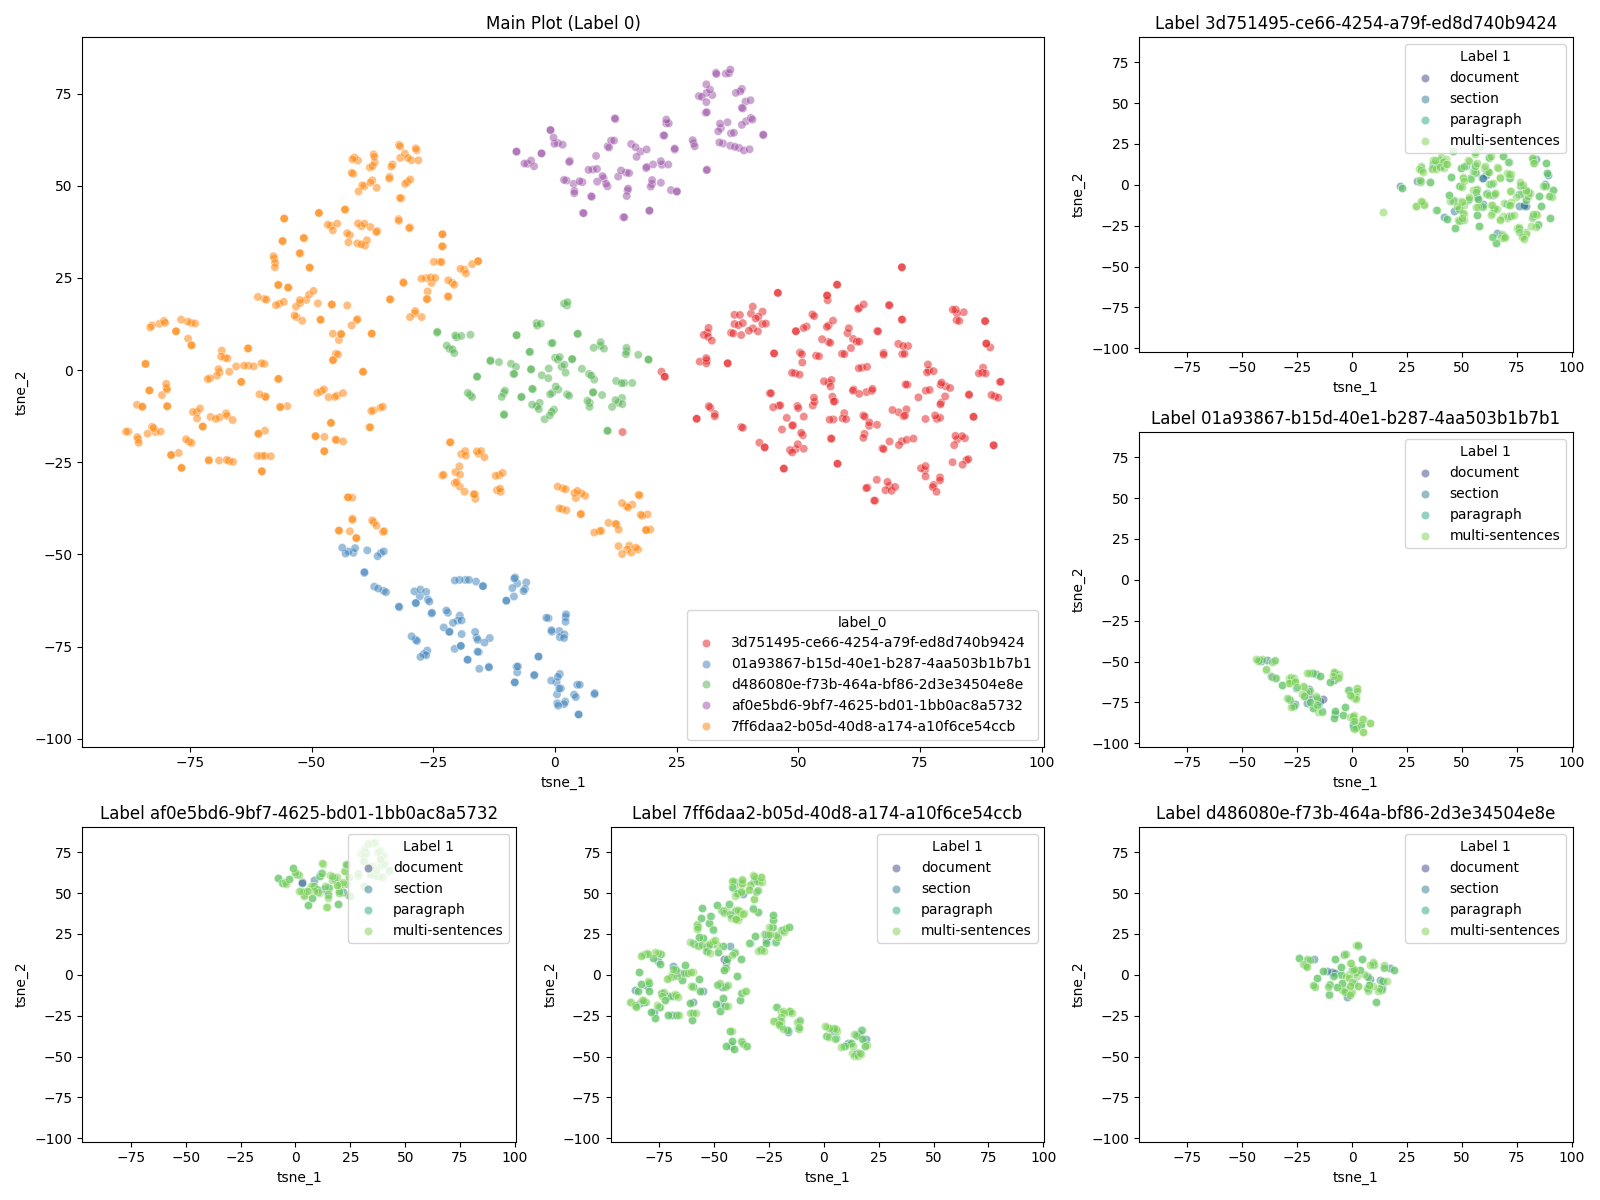

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

def blend_colors(color1, color2, alpha=0.5):
    """Blend two colors together with a given alpha."""
    return [(1 - alpha) * c1 + alpha * c2 for c1, c2 in zip(color1, color2)]

def plot_tsne_result(tsne_result_df, unique_labels, palette, nodes_file_name):
    """Plot TSNE result using a scatter plot with subplots for individual labels."""
    
    # Create a figure and a GridSpec layout with 3 rows and 3 columns
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    # Create the large plot on the left (spanning the first two rows and first two columns)
    ax_main = fig.add_subplot(gs[0:2, 0:2])
    
    # Use label_0 for the large plot
    sns.scatterplot(data=tsne_result_df, x='tsne_1', y='tsne_2', hue='label_0', palette=palette, ax=ax_main, alpha=0.5)
    ax_main.set_title('Main Plot (Label 0)')

    # Get x and y axis limits from the main plot
    xlim = ax_main.get_xlim()
    ylim = ax_main.get_ylim()

    # Get unique label_1 values
    unique_label_1 = tsne_result_df['label_1'].unique()

    # Create a distinct color palette for label_1
    label_1_palette = sns.color_palette("viridis", len(unique_label_1))  # Use the 'husl' palette for distinct colors

    # Create the 2x2 grid on the right for individual label plots
    for i, label in enumerate(unique_labels):
        if i < 2:
            ax = fig.add_subplot(gs[i, 2])  # First two plots in the first and second row, second column
        else:
            ax = fig.add_subplot(gs[2, i-3])  # Last two plots in the first and second row, third column
            
        label_data = tsne_result_df[tsne_result_df['label_0'] == label]  # Use label_0 for filtering
        
        # Plot each unique label_1 in the small plot
        for j, label_1 in enumerate(unique_label_1):
            sub_label_data = label_data[label_data['label_1'] == label_1]
            if not sub_label_data.empty:  # Only plot if there's data for this label_1
                # Blend the color for label_0 with the corresponding color from label_1
                blended_color = blend_colors(palette[i], label_1_palette[j], alpha=1)  # Adjust alpha as needed
                
                sns.scatterplot(data=sub_label_data, x='tsne_1', y='tsne_2', 
                                color=blended_color,  # Use the blended color
                                ax=ax, 
                                alpha=0.5,  # Keep it opaque for better visibility
                                label=label_1)

        # Set x and y limits to match the main plot
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_title(f'Label {label}')
        ax.legend(title='Label 1', loc='upper right')

    # Adjust layout and save the image
    plt.tight_layout()
    
    # Enable interactive mode
    # plt.ion()  # Use this in scripts to enable interactive mode
    plt.show()  # Show the plot
    plt.savefig(f"tsne_result_{nodes_file_name}.png")

# Assuming tsne_result_df is defined and contains the necessary columns
# Define unique labels and color palette
unique_labels = tsne_result_df['label_0'].unique().tolist()
palette = sns.color_palette('Set1', len(unique_labels))  # Adjust color palette as needed

# Plot and save the TSNE result
plot_tsne_result(
    tsne_result_df=tsne_result_df, 
    unique_labels=unique_labels,
    palette=palette, 
    nodes_file_name="tsne_5_sample"
)


In [72]:

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_tsne_result(tsne_result_df, unique_labels, palette, nodes_file_name):
    """Plot TSNE result using a scatter plot with subplots for individual labels."""
    # Create a figure and a GridSpec layout with 3 rows and 3 columns
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    # Create the large plot on the left (spanning the first two rows and first column)
    ax_main = fig.add_subplot(gs[0:2, 0:2])
    sns.scatterplot(data=tsne_result_df, x='tsne_1', y='tsne_2', hue='label', palette=palette, ax=ax_main, hue_order=unique_labels, alpha=0.5)
    ax_main.set_title('All Data')

    # Get x and y axis limits from the main plot
    xlim = ax_main.get_xlim()
    ylim = ax_main.get_ylim()

    # Create the 2x2 grid on the right for individual label plots
    for i, label in enumerate(unique_labels[:4]):
        if i < 2:
            ax = fig.add_subplot(gs[i, 2])  # First two plots in the first and second row, second column
        else:
            ax = fig.add_subplot(gs[2, i-3])  # Last two plots in the first and second row, third column
            
        label_data = tsne_result_df[tsne_result_df['label'] == label]
        sns.scatterplot(data=label_data, x='tsne_1', y='tsne_2', color=palette[i], ax=ax, alpha=0.8)

        # Set x and y limits to match the main plot
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_title(f'Label {label}')
        ax.legend([label], loc='upper right')

    # Create the two small plots at the bottom
    for i, label in enumerate(unique_labels[4:6]):
        ax = fig.add_subplot(gs[2, i+1])  # Bottom row, second and third columns
        label_data = tsne_result_df[tsne_result_df['label'] == label]
        sns.scatterplot(data=label_data, x='tsne_1', y='tsne_2', color=palette[i + 4], ax=ax, alpha=0.8)

        # Set x and y limits to match the main plot
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_title(f'Label {label}')
        ax.legend([label], loc='upper right')

    # Adjust layout and save the image
    plt.tight_layout()

    # Enable interactive mode
    plt.ion()  # Use this in scripts to enable interactive mode
    plt.show()  # Show the plot
    plt.savefig(f"tsne_result_{nodes_file_name}.png")

# Create a DataFrame with TSNE result and labels
# Define unique labels and color palette
# unique_labels = ['document', 'section', 'paragraph', 'multi-sentences']
unique_labels = tsne_result_df['label'].unique().tolist()
palette = sns.color_palette('Set1', len(unique_labels))

# Plot and save the TSNE result
plot_tsne_result(
    tsne_result_df=tsne_result_df, 
    unique_labels=unique_labels, 
    palette=palette, 
    nodes_file_name="tsne_5_sample"
)


KeyError: 'label'

### TSNE - queries

In [3]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib.gridspec import GridSpec

# ------------------ Data Loading Functions ------------------

def load_jsonl(file_path):
    embeddings = []
    levels = []
    with open(file_path, 'r') as f:
        for line in f:
            # Parse each line as JSON and append it to the list
            obj = json.loads(line)
            embeddings.append(obj['embedding'])
            levels.append(obj['level'])
    return np.array(embeddings), levels

# ------------------ TSNE and Data Preparation ------------------

def get_tsne_result(embeddings, n_components=2):
    """Generate TSNE result from embeddings."""
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result

def create_tsne_dataframe(tsne_result, levels):
    """Create a DataFrame with TSNE result and corresponding labels."""
    return pd.DataFrame({'tsne_1': tsne_result[:, 0], 'tsne_2': tsne_result[:, 1], 'label': levels})

# ------------------ Plotting Functions ------------------

def plot_tsne_result(tsne_result_df, unique_labels, palette, nodes_file_name):
    """Plot TSNE result using a scatter plot with subplots for individual labels."""
    # Create a figure and a GridSpec layout
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(2, 3, width_ratios=[2, 1, 1])

    # Create the large plot on the left (spanning both rows)
    ax_main = fig.add_subplot(gs[:, 0])
    sns.scatterplot(data=tsne_result_df, x='tsne_1', y='tsne_2', hue='label', palette=palette, ax=ax_main, alpha=0.5)
    ax_main.set_title('All Data')

    # Get x and y axis limits from the main plot
    xlim = ax_main.get_xlim()
    ylim = ax_main.get_ylim()

    # Create the 2x2 grid on the right for individual label plots
    for i, label in enumerate(unique_labels[:4]):
        ax = fig.add_subplot(gs[i // 2, i % 2 + 1])
        label_data = tsne_result_df[tsne_result_df['label'] == label]
        sns.scatterplot(data=label_data, x='tsne_1', y='tsne_2', color=palette[i], ax=ax, alpha=0.8)

        # Set x and y limits to match the main plot
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_title(f'Label {label}')
        ax.legend([label])

    # Adjust layout and save the image
    plt.tight_layout()
    plt.savefig(f"tsne_result_{nodes_file_name}.png")
    plt.close()

In [7]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.join('../..'))
from component.io import load_nodes_jsonl
# Load embeddings
embeddings_file_path = f"../step_1_get_embedding_value/questions/gpt-4o-batch-all-p_pid_0.jsonl"
nodes = load_nodes_jsonl(embeddings_file_path)
embeddings = np.array([node.embedding for node in nodes]).reshape(-1, 1)
levels = [node.metadata['level'] for node in nodes]

Loading gpt-4o-batch-all-p_pid_0.jsonl: 100%|██████████| 143M/143M [00:04<00:00, 32.1MB/s] 


In [8]:
# Generate TSNE result
tsne_result = get_tsne_result(embeddings, 2)

ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [5]:
# Create a DataFrame with TSNE result and labels
tsne_result_df = create_tsne_dataframe(tsne_result, levels)

# Define unique labels and color palette
unique_labels = tsne_result_df['label'].unique()
palette = sns.color_palette('Set1', len(unique_labels))

# Plot and save the TSNE result
plot_tsne_result(tsne_result_df, unique_labels, palette, embeddings_file_path.split('/')[-1].split('.')[0])

### Load data

In [24]:
import pandas as pd


In [25]:
# Load CSV file into DataFrame
df_pca = pd.read_hdf("cluster_result_pca.h5")

In [3]:
df_ae = pd.read_hdf("cluster_result_ae.h5")

In [30]:
df_kmeans = pd.read_hdf("cluster_result_kmeans.h5")

In [ ]:
import os, sys
sys.path.insert(0, os.path.abspath('.'))
from custom.io import load_nodes_jsonl

def load_nodes(pid_num, cache_dir):
    print("Loading nodes")
    file_name = f"gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_{pid_num}.jsonl"
    file_path = os.path.join(cache_dir, file_name)
    nodes = load_nodes_jsonl(file_path)
    return nodes

nodes = load_nodes(1, os.path.abspath('./.save'))

### PCA

In [ ]:
df_pca

In [ ]:
import os, sys
sys.path.insert(0, os.path.abspath('.'))
from custom.io import load_nodes_jsonl

def load_nodes(pid_num, cache_dir):
    print("Loading nodes")
    file_name = f"gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_{pid_num}.jsonl"
    file_path = os.path.join(cache_dir, file_name)
    nodes = load_nodes_jsonl(file_path)
    return nodes

nodes = load_nodes(1, os.path.abspath('./.save'))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_kmeans['kmean_labels'], cmap='viridis', s = 50, alpha=0.5) 

# Create the scatter plot
# level2int = {level : i for i, level in enumerate(['document', 'section', 'paragraph', 'multi-sentences'])}
# scatter = plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=[level2int[node.metadata['level']] for node in nodes], cmap='viridis', s = 50, alpha=0.5) 
# Reverse the mapping for easy label creation
# int2level = {v: k for k, v in level2int.items()}

# Set the ticks to match the integer labels for the levels
# cbar = plt.colorbar(scatter, label='labels')
# cbar.set_ticks([0, 1, 2, 3])
# cbar.set_ticklabels(['document', 'section', 'paragraph', 'multi-sentences'])

# Create a legend using custom patches
# handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(level2int[level])), label=level) 
#            for level in level2int]
unique_labels = np.unique(df_kmeans['kmean_labels'])
# handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(level2int[level])), label=level) 
#            for level in level2int]
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(label)), label=f'Label {label}') for label in unique_labels]

# Add the legend to the plot (in the upper right corner)
plt.legend(handles=handles, title="Labels", loc='upper right')


# Add labels to the points
# for i, node in enumerate(nodes):
#     label = node.metadata['level']  # Get the text label
#     plt.text(df_pca['PCA1'].iloc[i], df_pca['PCA2'].iloc[i], label, fontsize=8, ha='right', color='black')

# Add titles and labels
plt.title('PCA of Clustered Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### AutoEncoder

In [ ]:
df_ae

In [21]:
selected_node = [node.metadata['level'] in ['document', 'section', 'paragraph', 'multi-sentences'] for node in nodes]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plot the results
plt.figure(figsize=(10, 8))
# scatter = plt.scatter(df_ae['AE1'], df_ae['AE2'], c=df_kmeans['kmean_labels'], cmap='viridis', s=50)

# Create the scatter plot
level2int = {level : i for i, level in enumerate(['document', 'section', 'paragraph', 'multi-sentences'])}
scatter = plt.scatter(df_ae['AE1'][selected_node], df_ae['AE2'][selected_node], c=[level2int[node.metadata['level']] for i, node in enumerate(nodes) if selected_node[i]], cmap='viridis', s = 50, alpha=0.5) 
# Reverse the mapping for easy label creation
int2level = {v: k for k, v in level2int.items()}

# Create a legend using custom patches
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(level2int[level])), label=level) 
           for level in level2int]

# Add the legend to the plot (in the upper right corner)
plt.legend(handles=handles, title="Labels", loc='upper right')

plt.title('AutoEncoder of Clustered Embeddings')
plt.xlabel('AutoEncoder Component 1')
plt.ylabel('AutoEncoder Component 2')
plt.show()

# Plot the results
plt.figure(figsize=(10, 8))
# scatter = plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_kmeans['kmean_labels'], cmap='viridis', s = 50, alpha=0.5) 


# Set the ticks to match the integer labels for the levels
# cbar = plt.colorbar(scatter, label='labels')
# cbar.set_ticks([0, 1, 2, 3])
# cbar.set_ticklabels(['document', 'section', 'paragraph', 'multi-sentences'])
